<font size="6">Fractional Maximum Likelihood Estimation</font>

TBD

<font size="5">Purpose</font>

Fractional MLE

<font size="5">Method</font>

TBD

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn 
import sklearn.mixture as mix 

In [2]:
assetlist = [ 'IEF', 'GSG', 'IXN' ]
num_components = 99

Create the subset of assets. We end up with a 3-dimensional multivariate gaussian system. 

In [3]:
m6 = pd.read_csv('./data/assets_m6_2022.csv')
m6_assets = pd.DataFrame()

for sym in assetlist: 
    m6_assets[sym] = m6[m6['symbol'] == sym]['price'].values

<font size="5">Z-Scoring & Auto-Correlation Decay Plots</font>

Formatting the training data. There is only training data and no test data in this exercise (it is a purely descriptive exercise). Z-scored measurements of the log price for each asset based on a rolling window. At timepoint 't' the window looks back 'w' steps to calculate mu and sigma. 

$$\huge z_t = \frac{x_t - \mu_{t-w:t}}{\sigma_{t-w:t}}$$

There are regions where the current log price is either above or below its running average (as measured in units of standard deviation) and this formatting of the data preserves long memory based on looking at the auto-correlation decay plots. <b>It is important that the running average never takes into account future data which would introduce lookahead bias, so a rolling metric based on the list comprehension is used.</b> 

The ACF function is defined as follows, 

$$ \huge \operatorname{ACF}(\tau) = \frac{\sum_{t=1}^{n-\tau} (x_t - \bar{x})(x_{t+\tau} - \bar{x})}{\sum_{t=1}^n (x_t - \bar{x})^2} $$

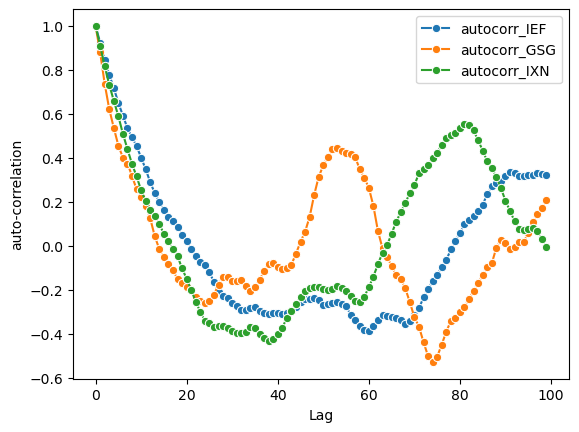

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
--cholesky simulated--


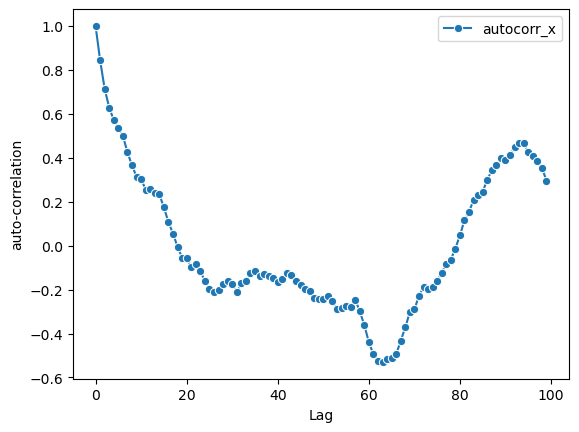

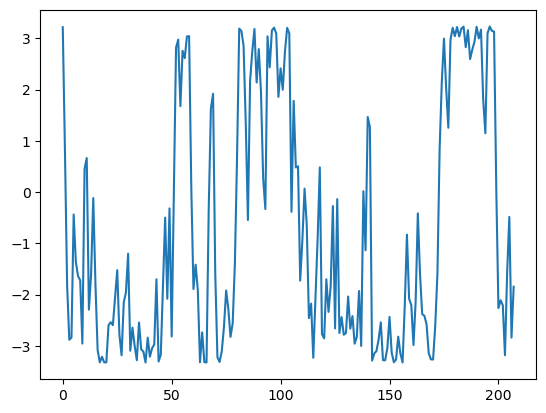

Estimated Mean: -0.7325357717620501
Estimated Variance: 5.5718933683550755
Estimated Auto-covariance:
 [[1.78696942e+00 9.68745207e-01 1.70969266e-01 ... 1.16728426e-05
  4.71347536e-04 8.24502929e-05]
 [9.68745207e-01 1.78696942e+00 1.01903279e+00 ... 1.41137638e-03
  2.28274585e-02 6.27768713e-03]
 [1.70969266e-01 1.01903279e+00 1.78696942e+00 ... 4.42160330e-02
  2.97728354e-01 1.26286766e-01]
 ...
 [1.16728426e-05 1.41137638e-03 4.42160330e-02 ... 1.78696942e+00
  1.26962524e+00 1.63751927e+00]
 [4.71347536e-04 2.28274585e-02 2.97728354e-01 ... 1.26962524e+00
  1.78696942e+00 1.64368302e+00]
 [8.24502929e-05 6.27768713e-03 1.26286766e-01 ... 1.63751927e+00
  1.64368302e+00 1.78696942e+00]]


In [79]:
import scipy.stats as stats
m6_subset1 = m6_assets.copy()

# Window length 25 days
wlen = 25

# First convert to log price 
m6_subset1 = m6_subset1.apply(np.log)

# Clean data
m6_subset1 = m6_subset1.dropna().reset_index().drop(columns='index')

# Apply z-score in a rolling way that does not create lookahead bias 
rolling_zscore = lambda serie: [ stats.zscore(serie[x-wlen:x]).values[-1] for x in range(wlen, len(serie) + 1) ]

m6_subset = pd.DataFrame()
m6_subset['IEF'] = rolling_zscore(m6_subset1['IEF'])
m6_subset['GSG'] = rolling_zscore(m6_subset1['GSG'])
m6_subset['IXN'] = rolling_zscore(m6_subset1['IXN'])

# View Auto Correlation
decay_func = lambda S, _range: [S.autocorr(lag=Lag) for Lag in _range]
sns.lineplot(data=decay_func(m6_subset['IEF'], range(0, 100)), label='autocorr_IEF', marker='o') 
sns.lineplot(data=decay_func(m6_subset['GSG'], range(0, 100)), label='autocorr_GSG', marker='o')
sns.lineplot(data=decay_func(m6_subset['IXN'], range(0, 100)), label='autocorr_IXN', marker='o')
plt.xlabel('Lag')
plt.ylabel('auto-correlation')
plt.show()

%pip install torch
%pip install gpytorch
import torch
import gpytorch
import scipy 

class FractionalMLE:
    def __init__(self, data):
        self.data = np.array(data)
        self.n = len(data)
        self.mean = None
        self.variance = None
        self.auto_covariance = None
    
    def fit(self):
        
        # Fit
        x = self.data
        kernel = gpytorch.kernels.RBFKernel(lengthscale=0.1)
        kernel_autocov = kernel(torch.tensor(x).unsqueeze(1)).evaluate()

        # Compute the auto-covariance matrix using the RBFKernel
        self.auto_covariance = (kernel_autocov * np.var(x)).detach().numpy()
        
        # Add a small positive constant to the diagonal of the matrix
        j = 1e-7
        C = self.auto_covariance + (j * np.eye(len(x)))

        # Compute the lower triangular matrix L using Cholesky decomposition
        L = np.linalg.cholesky(C)

        # Generate a random vector
        z = np.random.normal(size=len(x)) 

        # Multiply L by z 
        LLz = np.mean(x) + np.dot(L, z) 
        
        # Estimate mean and variance from the data
        self.mean = np.mean(LLz)
        self.variance = np.var(LLz)
        
        # Xdf 
        print('--cholesky simulated--')
        xdf=pd.DataFrame()
        xdf['LLz']=LLz
        sns.lineplot(data=decay_func(xdf['LLz'], range(0, 100)), label='autocorr_x', marker='o') 
        plt.xlabel('Lag')
        plt.ylabel('auto-correlation')
        plt.show()

        sns.lineplot(data=LLz)
        plt.show()
        
# Example usage
data = m6_subset['IEF'].values
fractional_mle = FractionalMLE(data)
fractional_mle.fit()

print("Estimated Mean:", fractional_mle.mean)
print("Estimated Variance:", fractional_mle.variance)
print("Estimated Auto-covariance:\n", fractional_mle.auto_covariance)


Instantiate a non-parametric model using the dirichlet process and view the clustering results on the training data. The shaded regions on the plot represent the final state the system lands on, states[-1]. 

In [70]:
dpgmm_model = mix.BayesianGaussianMixture(n_components=num_components, 
                                          weight_concentration_prior_type='dirichlet_process', 
                                          n_init=10, 
                                          max_iter=1000000)

In [71]:
dpgmm_model.fit(m6_subset)
states = dpgmm_model.predict(m6_subset)

state_counts = np.zeros(num_components)
for M in states:
  state_counts[M] += 1 

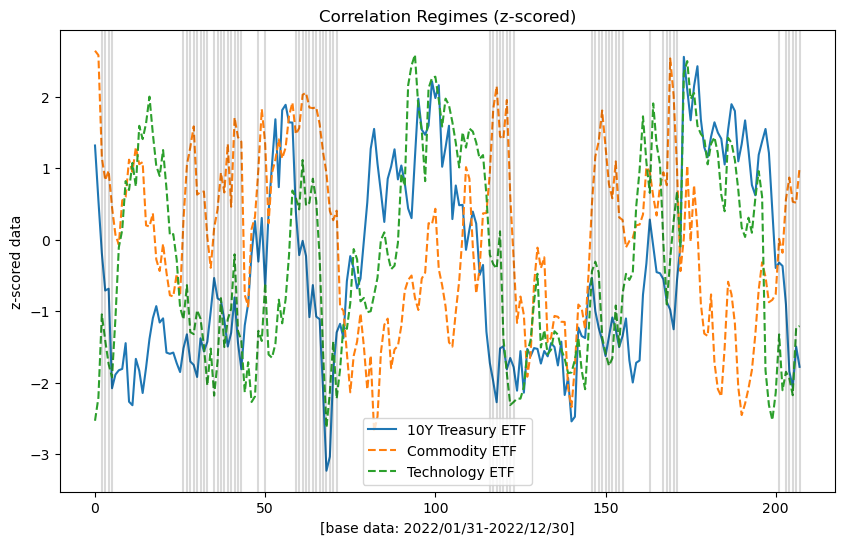

state_counts=
[66.  0.  0.  0.  0. 66. 18.  0. 58.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
means for shaded state=
[-1.22375512  0.98807462 -0.94650517]


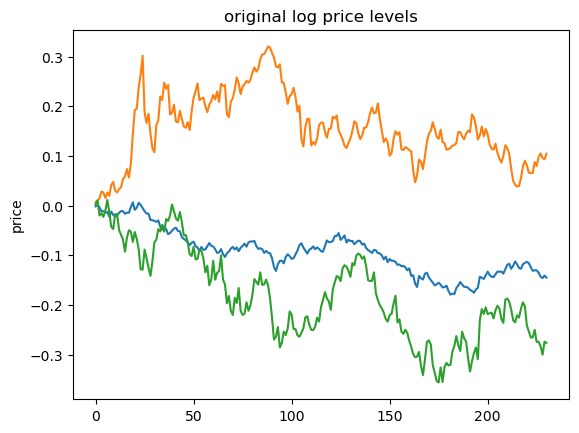

In [72]:
fig,ax = plt.subplots(figsize=(10, 6
                              ))
sns.lineplot(x=m6_subset.index, y=m6_subset['IEF'], ax=ax, label='10Y Treasury ETF')
sns.lineplot(x=m6_subset.index, y=m6_subset['GSG'], ax=ax, label='Commodity ETF', linestyle='--')
sns.lineplot(x=m6_subset.index, y=m6_subset['IXN'], ax=ax, label='Technology ETF', linestyle='--')

for M in range(len(states)): 
  if states[M] == states[-1]:
    ax.axvline(M, color='black', alpha=0.15)

ax.set_title('Correlation Regimes (z-scored)')
ax.set_ylabel('z-scored data')
ax.set_xlabel(f'[base data: 2022/01/31-2022/12/30]')
plt.show()

print('state_counts=')
print(state_counts)

print('means for shaded state=')
print(dpgmm_model.means_[states[-1]])

sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IEF'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['GSG'])
sns.lineplot(data=m6_assets.copy().apply(np.log).apply(np.diff).cumsum()['IXN'])
plt.title('original log price levels')
plt.ylabel('price')
plt.show()

<font size=5> Precision Matrices Graph </font>

Note: you may need to restart the kernel to use updated packages.


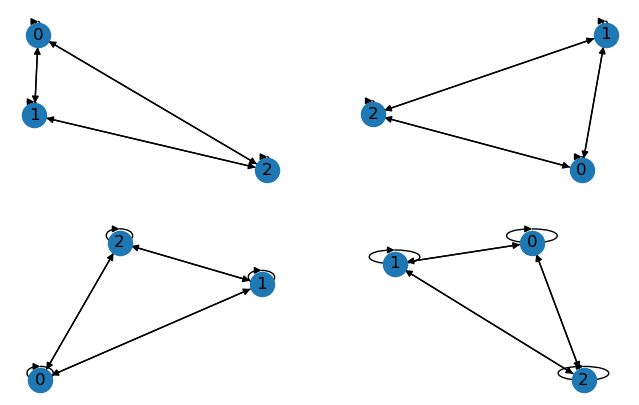

In [73]:
%pip install networkx 
import networkx as nx
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

i = 0
j = 0 
for pmat in dpgmm_model.precisions_:
    if state_counts[i] > 0: 
        ax = axes[j//2][j%2]
        G = nx.DiGraph(pmat)
        nx.draw(G, with_labels=True, ax=ax)
        j += 1
    i += 1

plt.show()